In [ ]:
# ## Relationship for combination of variables
az.plot_pair(idata_hierar, textsize=12);

### Initial setup

In [1]:
# --- Import libraries --- #

import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
# --- Read data --- #

data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
# --- Exclude compounds with missing values --- #

data_nonmiss = data.dropna()
# 23 compounds: one DNT negative and all the others DNT positive

In [4]:
# --- Standardisation --- #

# Continuous values
data_prep = data_nonmiss.loc[:, ('SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH')]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']
data_scaled = data_scaled.set_index(data_nonmiss.Chemical)

# Add other discrete values and details
discrete = data_nonmiss.loc[:, ('CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF')]
data_discrete = pd.DataFrame(discrete)
data_discrete = data_discrete.set_index(data_nonmiss.Chemical)
data_final = data_discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [5]:
# --- Define predictors and outcomes --- #

# BDNF given by discrete variables
x_bdnf_binary = pd.DataFrame(data_final[['BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
# BDNF given by continuous variables
x_bdnf_continue = pd.DataFrame(data_final[['SLogP', 'Cbrain/Cblood']]).values
y_bdnf = pd.DataFrame(data_final[['BDNF, Reduction']]).values

# Syn
x_syn = pd.DataFrame(data_final[['Syn_EC30', 'Viability_EC30']]).values
y_syn = pd.DataFrame(data_final[['Activity_Syn']]).values

# NNF
x_nnf = pd.DataFrame(data_final[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
y_nnf = pd.DataFrame(data_final[['Activity_NNF']]).values

# DNT
# x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
y_dnt = pd.DataFrame(data_final[['DNT']]).values

### Causal model

In [6]:
# --- Define and fit the model --- #

with pm.Model() as model_causal:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=10, sd=1) 
    sd_beta = pm.HalfNormal('sd_beta', sd=2)
    # Define priors
    beta_bdnf_binary = pm.Bernoulli('beta_bdnf_binary', p=0.5, shape=(4,1))
    beta_bdnf_continue = pm.Normal('beta_bdnf_continue', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))
    # Define BDNF 
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(x_bdnf_binary, beta_bdnf_binary) + 
                              pm.math.dot(x_bdnf_continue, beta_bdnf_continue)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=y_bdnf)
    # Define SYN 
    # BDNF + EC30, Viability -> SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(x_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p = lp_syn, observed=y_syn)
    # Define NNF 
    # SYN + EC50min, EC50max, Viability -> NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(x_nnf, beta_nnf))
    y_obs_nnf = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=y_nnf)
    # Define DNT 
    # BDNF -> SYN -> NNF -> DNT <- BDNF
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=y_dnt)

# Checking the proposed structure of model
model_causal.check_test_point()

mu_beta                -0.92
sd_beta_log__          -0.77
beta_bdnf_binary       -2.77
beta_bdnf_continue     -2.77
beta_syn               -2.77
beta_nnf               -4.16
y_obs_bdnf           -201.09
y_obs_syn             -87.29
y_obs_nnf            -227.21
y_obs_dnt            -620.64
Name: Log-probability of test_point, dtype: float64

In [7]:
# Make the inferences
with model_causal:
    trace_causal = pm.sample(cores=4) #return_inferencedata=True,

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_nnf, beta_syn, beta_bdnf_continue, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [beta_bdnf_binary]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.


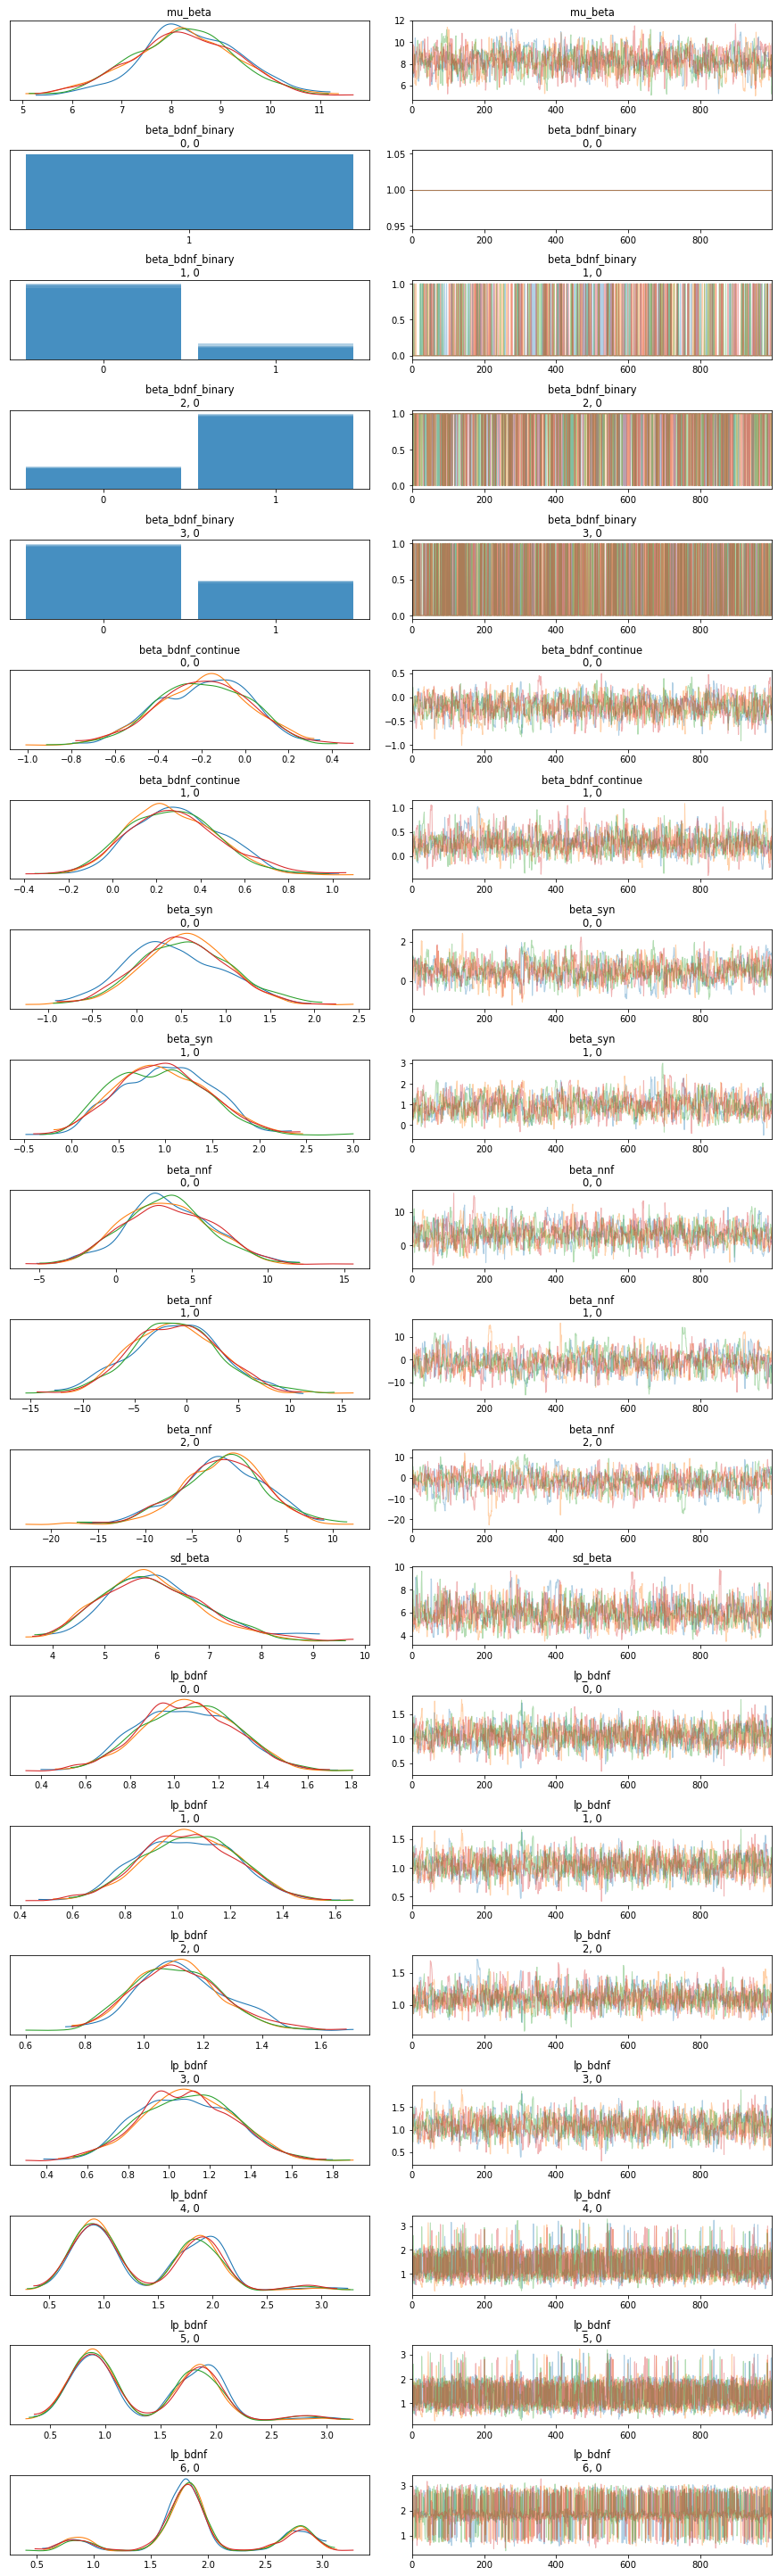

In [9]:
# Plot the traces
pm.plot_trace(trace_causal);

### Multivariate model

In [7]:
# --- Define and fit the model --- #

with pm.Model() as model_mvn:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=10, sd=1) 
    sd_beta = pm.HalfNormal('sd_beta', sd=2)
    # Define priors
    beta_bdnf_binary = pm.Bernoulli('beta_bdnf_binary', p=0.5, shape=(4,1))
    beta_bdnf_continue = pm.Normal('beta_bdnf_continue', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))
    # LKJ prior for covariance matrix for BDNF binary   
    bdnf_chol_binary, corr, stds = pm.LKJCholeskyCov(
        'bdnf_chol_binary', n=4, eta=8.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False)
    mu_bdnf_binary = pm.Bernoulli('mu_bdnf_binary', p=0.5, shape=4)
    x_bdnf_mvn_binary = pm.MvNormal('x_bdnf_mvn_binary', mu=mu_bdnf_binary, 
                                    chol=bdnf_chol_binary, observed=x_bdnf_binary)
    
     # LKJ prior for covariance matrix for BDNF binary   
    bdnf_chol_continue, corr, stds = pm.LKJCholeskyCov(
        'bdnf_chol_continue', n=2, eta=8.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False)
    mu_bdnf_continue = pm.Normal('mu_bdnf_continue', mu=10, sd=1, shape=2)   
    
    x_bdnf_mvn_continue = pm.MvNormal('x_bdnf_mvn_continue', mu=mu_bdnf_continue, 
                                      chol=bdnf_chol_continue, observed=x_bdnf_continue)
    
    # Define BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf =  pm.Deterministic('lp_bdnf', tt.dot(x_bdnf_mvn_binary, beta_bdnf_binary) + 
                               tt.dot(x_bdnf_mvn_continue, beta_bdnf_continue))    
    y_obs_bdnf = pm.Bernoulli("y_obs_bdnf", logit_p=lp_bdnf, observed=y_bdnf)
    
    #LKJ prior for covariance matrix for SYN    
    syn_chol, corr, stds = pm.LKJCholeskyCov(
        'syn_chol', n=2, eta=8.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_syn = pm.Normal('mu_syn', mu=10, sd=1, shape=2)
    x_syn = pm.MvNormal('x_syn', mu=mu_syn, chol=syn_chol, observed=x_syn)
    
    # Likelihood for Syn
    # BDNF + EC30, Viability -> SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(x_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p=lp_syn, observed=y_syn)
    
    #LKJ prior for covariance matrix for NNF 
    nnf_chol, corr, stds = pm.LKJCholeskyCov(
        'nnf_chol', n=3, eta=8.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_nnf = pm.Normal('mu_nnf', mu=0, sd=1, shape=3)
    x_nnf = pm.MvNormal('x_nnf', mu=mu_nnf, chol=nnf_chol, observed=x_nnf)
    
    # Likelihood for NNF
    # SYN + EC50min, EC50max, Viability -> NNF
    lp_nnf =  pm.Deterministic('lp_nnf', lp_syn + tt.dot(x_nnf, beta_nnf))    
    y_obs_nnf = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=y_nnf)
    
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=y_dnt)
    
# Checking the proposed structure of model
model_mvn.check_test_point()

mu_beta                                      -0.92
sd_beta_log__                                -0.77
beta_bdnf_binary                             -2.77
beta_bdnf_continue                           -2.77
beta_syn                                     -2.77
beta_nnf                                     -4.16
bdnf_chol_binary_cholesky-cov-packed__       -0.44
mu_bdnf_binary                               -3.68
bdnf_chol_continue_cholesky-cov-packed__     -0.76
mu_bdnf_continue                             -1.84
syn_chol_cholesky-cov-packed__               -0.76
mu_syn                                       -1.84
nnf_chol_cholesky-cov-packed__               -0.58
mu_nnf                                       -2.76
x_bdnf_mvn_binary                           -99.04
x_bdnf_mvn_continue                         -65.27
y_obs_bdnf                                 -201.09
x_syn                                       -65.27
y_obs_syn                                   -87.29
x_nnf                          

In [8]:
# Make the inferences
with model_mvn:
    trace_mvn = pm.sample(cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_nnf, nnf_chol, mu_syn, syn_chol, mu_bdnf_continue, bdnf_chol_continue, mu_bdnf_binary, bdnf_chol_binary, beta_nnf, beta_syn, beta_bdnf_continue, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [beta_bdnf_binary]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 643 seconds.
There were 876 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35657851962612486, but should be close to 0.8. Try to increase the number of tuning steps.
There were 891 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39204152734722575, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# Plot the traces
pm.plot_trace(trace_mvn);

### Non-causal model

In [8]:
# --- Define and fit the model --- #

with pm.Model() as model_noncausal:
# Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=10, sd=1) 
    sd_beta = pm.HalfNormal('sd_beta', sd=2)
    # Define priors
    beta_bdnf_binary = pm.Bernoulli('beta_bdnf_binary', p=0.5, shape=(4,1))
    beta_bdnf_continue = pm.Normal('beta_bdnf_continue', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))
    # Define BDNF 
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(x_bdnf_binary, beta_bdnf_binary) + 
                              pm.math.dot(x_bdnf_continue, beta_bdnf_continue)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=y_bdnf)
    # Define SYN 
    # EC30, Viability -> SYN
    lp_syn =  pm.Deterministic('lp_syn', pm.math.dot(x_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p = lp_syn, observed=y_syn)
    # Define NNF 
    # EC50min, EC50max, Viability -> NNF
    lp_nnf = pm.Deterministic('lp_nnf', pm.math.dot(x_nnf, beta_nnf))
    y_obs_nnf = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=y_nnf)
    # Define DNT 
    # BDNF -> SYN -> NNF -> DNT <- BDNF
    #lp_dnt = pm.Deterministic('lp_dnt', pm.math.dot(x_bdnf_binary, beta_bdnf_binary) + 
                              #pm.math.dot(x_bdnf_continue, beta_bdnf_continue) + 
                             #pm.math.dot(x_syn, beta_syn) +  pm.math.dot(x_nnf, beta_nnf))
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=y_dnt)
# Checking the proposed structure of model
model_noncausal.check_test_point()

mu_beta                -0.92
sd_beta_log__          -0.77
beta_bdnf_binary       -2.77
beta_bdnf_continue     -2.77
beta_syn               -2.77
beta_nnf               -4.16
y_obs_bdnf           -201.09
y_obs_syn             -45.12
y_obs_nnf            -118.59
y_obs_dnt            -289.16
Name: Log-probability of test_point, dtype: float64

In [9]:
# Make the inferences
with model_noncausal:
    trace_noncausal = pm.sample(cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_nnf, beta_syn, beta_bdnf_continue, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [beta_bdnf_binary]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


### Comparison

In [11]:
# ## Define labels for plots
ylabels= data_nonmiss["Chemical"].astype(str) + " (" + data_nonmiss["CASRN"].astype(str) + ")"

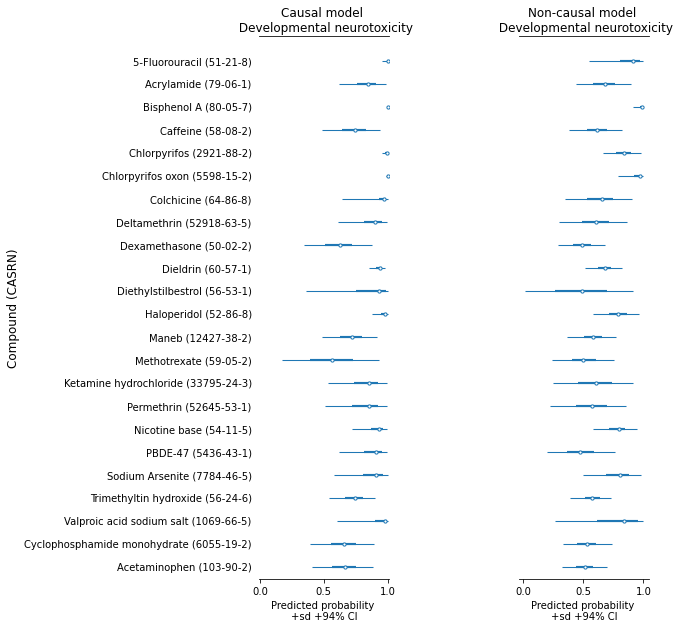

In [12]:
# ## Forestplots with underlying the compounds tested in both studies
fig, ax = plt.subplots(1, 2, figsize=(7,10), sharey=True)


ax0 = pm.forestplot(trace_causal, 
                   var_names='lp_dnt', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[0])
ax1 = pm.forestplot(trace_noncausal, 
                   var_names='lp_dnt', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[1])

ax[0].set_yticklabels(ylabels[::-1])

ax[0].set_xlim([-0.01,1.01])
ax[0].set_xlabel("Predicted probability \n+sd +94% CI")
ax[1].set_xlabel("Predicted probability \n+sd +94% CI")

ax[0].set_ylabel("Compound (CASRN)", fontsize=12)
ax[0].set_title("Causal model \n Developmental neurotoxicity", fontsize=12)
ax[1].set_title("Non-causal model \n Developmental neurotoxicity", fontsize=12)

plt.subplots_adjust(wspace=1);

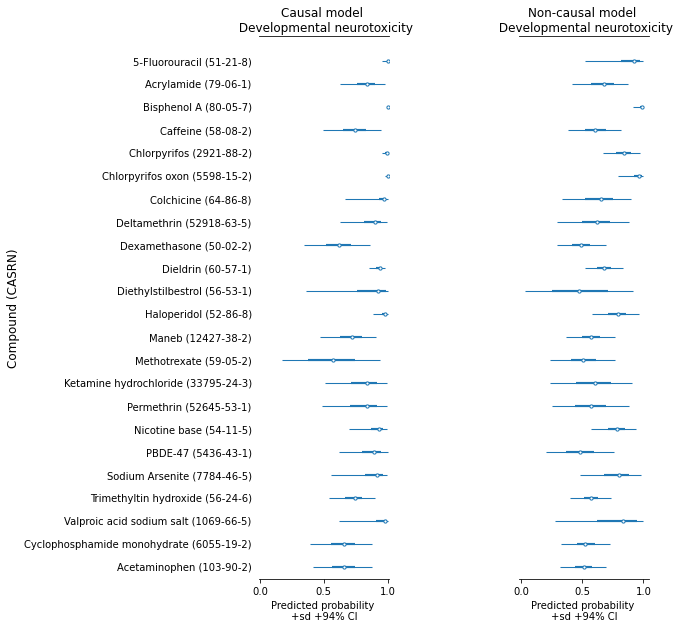

In [22]:
# ## Forestplots with underlying the compounds tested in both studies
fig, ax = plt.subplots(1, 2, figsize=(7,10), sharey=True)


ax0 = pm.forestplot(trace_causal, 
                   var_names='lp_dnt', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[0])
ax1 = pm.forestplot(trace_noncausal, 
                   var_names='lp_dnt', combined=True, transform=logistic, hdi_prob=0.94,
                   textsize=10, ax = ax[1])

ax[0].set_yticklabels(ylabels[::-1])

ax[0].set_xlim([-0.01,1.01])
ax[0].set_xlabel("Predicted probability \n+sd +94% CI")
ax[1].set_xlabel("Predicted probability \n+sd +94% CI")

ax[0].set_ylabel("Compound (CASRN)", fontsize=12)
ax[0].set_title("Causal model \n Developmental neurotoxicity", fontsize=12)
ax[1].set_title("Non-causal model \n Developmental neurotoxicity", fontsize=12)

plt.subplots_adjust(wspace=1);

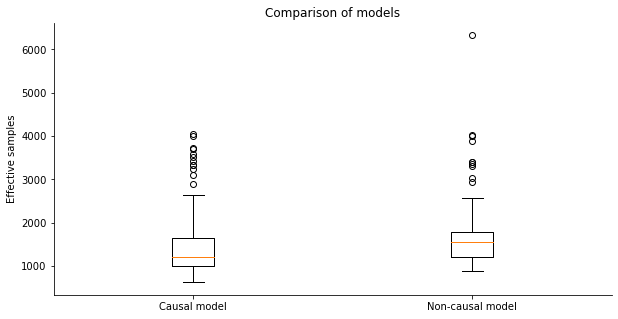

In [13]:
# ESS

# extract n_eff values for each model
neff_causal = az.summary(trace_causal)['ess_bulk'].values
neff_noncausal = az.summary(trace_noncausal)['ess_bulk'].values

# plot distributions
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.boxplot([neff_causal, neff_noncausal], labels=["Causal model", "Non-causal model"]);
#ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Effective samples');
ax.set_title('Comparison of models')
sns.despine(right=True, top=True)

In [ ]:
# Hyperpriors and priors


In [ ]:
# LOO


In [ ]:
# WAIC
